In [1]:
class ModelActivations:
    def __init__(self, model, layers):
        self.model = model
        self.layers = layers
        self.activations = {}
        self.handles = []

    def _save_activation(self, name):
            def hook(module, inp, out):
                self.activations[name] = out.detach()
            return hook
    
    def register_hooks(self, layer=None):
        for name, module in self.model.named_modules():
            if layer is not None:
                if name == layer:
                    if name not in self.layers:
                        self.layers.append(layer)
                    handle = module.register_forward_hook(self._save_activation(name))
                    self.handles.append(handle)
            else:
                if name in self.layers:
                    handle = module.register_forward_hook(self._save_activation(name))
                    self.handles.append(handle)

    def fetch_activations(self, layer_name):
        return self.activations.get(layer_name, None)

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn.linear_model import Ridge
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from matplotlib import pyplot, image
from sklearn.model_selection import StratifiedKFold
from scipy.stats import pearsonr
import numpy as np

class NeuralDataStimuli(Dataset):
    def __init__(self, benchmark_assembly, trnsfrms=None):
        self.benchmark_assembly = benchmark_assembly
        self.stimulus_set = benchmark_assembly.stimulus_set
        self.transform = trnsfrms
        self.groups = self.stimulus_set["category_name"].tolist()

    def __len__(self):
        return len(self.stimulus_set)

    def __getitem__(self, idx):
        stimulus_id = self.stimulus_set['stimulus_id'].values[idx]
        local_path = self.stimulus_set.get_stimulus(stimulus_id)
        img = image.imread(local_path)
        img = transforms.ToPILImage()(img)
        trsfm = transforms.Compose([
            transforms.Resize(32),
            transforms.CenterCrop(32),
            transforms.ToTensor(),
        ])
        if self.transform:
            img = self.transform(img)
        else:
            img = trsfm(img)
        neural_response = self.benchmark_assembly.data[idx]
        return img, neural_response
    
def fetch_activation_matrices(model, dataset, activation_layer="fc1", transforms=None, num_iterations=None):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print("using device:", device)
    model = model.to(device)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)
    all_neural_responses = []
    all_model_hidden_activations = []
    # activations = {}
    # def save_activation(name):
    #     def hook(module, inp, out):
    #         activations[name] = out.detach()
    #     return hook

    # handles = []

    # for name, module in model.named_modules():
    #     if name == activation_layer:
    #         handles.append(module.register_forward_hook(save_activation(name)))

    activations_recorder = ModelActivations(model, layers=[activation_layer])
    activations_recorder.register_hooks()


    model.eval()
    for i, (images, neural_responses) in enumerate(dataloader):
        if num_iterations is not None and i >= num_iterations:
            break
        images = images.to(device)
        neural_responses = neural_responses.to(device)
        _ = model(images)

        activations_batch = activations_recorder.fetch_activations(activation_layer)
        if activations_batch.ndim == 4:
                # global average pool to [B, 512, 1, 1]
            activations_batch = torch.nn.functional.adaptive_avg_pool2d(activations_batch, 1)
        all_neural_responses.append(neural_responses)
        all_model_hidden_activations.append(activations_batch)
    all_neural_responses = torch.cat(all_neural_responses, dim=0)
    all_model_hidden_activations = torch.cat(all_model_hidden_activations, dim=0)
    all_model_hidden_activations = all_model_hidden_activations.view(all_model_hidden_activations.size(0), -1)
    return all_neural_responses, all_model_hidden_activations

In [4]:
from scipy import stats

def predictivity(x, y, rho_xx, rho_yy):
    assert x.shape == y.shape, "Input and prediction shapes must match"
    n_neurons = x.shape[1]

    raw_corr = np.array([stats.pearsonr(x[:, i], y[:, i])[0] for i in range(n_neurons)])
    denominator = np.sqrt(rho_xx * rho_yy)
    corrected_raw_corr = raw_corr / denominator
    ev = (corrected_raw_corr ** 2) * 100
    # ev = corrected_raw_corr
    return ev

In [25]:
# from src.models.basic_cnn import BasicCNN
import brainscore_vision
from torchvision import transforms
from  torchvision import models

resnet18 = models.resnet18(pretrained=True)
# cnn = BasicCNN(in_channels=1, out_channels=10)
benchmark = brainscore_vision.load_benchmark('MajajHong2015public.IT-pls')


In [26]:
from brainscore_vision import load_model
model = load_model("compact_resnet50_robust_IT")

brainscore-storage/brainscore-vision/models/user_718/compact_ResNet50_robust_IT_50filters.pt: 100%|██████████| 1.46M/1.46M [00:00<00:00, 3.44MB/s]


In [6]:
class BasicCNN(torch.nn.Module):
    def __init__(self, in_channels=1, out_channels=10):
        super(BasicCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.fc1 = torch.nn.Linear(32 * 56 * 56, 128)
        self.fc2 = torch.nn.Linear(128, out_channels)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = BasicCNN(in_channels=1, out_channels=10) 

In [7]:
stimuli_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: transforms.functional.rgb_to_grayscale(x, num_output_channels=1)),
    transforms.Normalize(mean=[0.286], std=[0.352]),
    ])
three_channel_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

In [8]:
dataset = NeuralDataStimuli(benchmark._assembly, trnsfrms=stimuli_transform)

In [9]:
neural_data = brainscore_vision.load_dataset("MajajHong2015.public")
neural_data = neural_data.transpose('presentation', 'neuroid', 'time_bin')

benchmark_data_full = neural_data.sel(region='IT')
benchmark_data_full = benchmark_data_full.squeeze('time_bin')  # (3)
benchmark_data_full.data

dask.array<getitem, shape=(148480, 168), dtype=float32, chunksize=(148480, 168), chunktype=numpy.ndarray>

In [10]:
import pandas as pd

da = benchmark_data_full  # dims: ('presentation', 'neuroid')

# 1. Inspect what levels you have
print(da.indexes["presentation"].names)
# e.g. ['image_id', 'repetition', 'id', 'stimulus_id', 'background_id', ...]

# 2. Build a *new* MultiIndex using only the levels you care about
old_index = da.indexes["presentation"]

image_ids = old_index.get_level_values("image_id")      # or 'stimulus_id'
reps      = old_index.get_level_values("repetition")

new_index = pd.MultiIndex.from_arrays(
    [image_ids, reps],
    names=["image_id", "repetition"],
)

# 3. Reassign this simplified MultiIndex to the 'presentation' coord
da2 = da.copy()
da2 = da2.assign_coords(presentation=("presentation", new_index))

# 4. Now unstack – product space is just image_id × repetition
da_u = da2.unstack("presentation")

print(da_u.dims)
# expected: ('image_id', 'repetition', 'neuroid')  (plus time_bin if present)

# 5. Put in desired order and extract numpy array
da_u = da_u.transpose("image_id", "neuroid", "repetition")
matrix = da_u.values   # shape: (n_stimuli, n_reps, n_neurons)


['image_id', 'repetition', 'stimulus', 'stimulus_id', 'id', 'background_id', 's', 'image_file_name', 'filename', 'rxy', 'tz', 'category_name', 'rxz_semantic', 'ty', 'ryz', 'object_name', 'variation', 'size', 'rxy_semantic', 'ryz_semantic', 'rxz']
('neuroid', 'image_id', 'repetition')


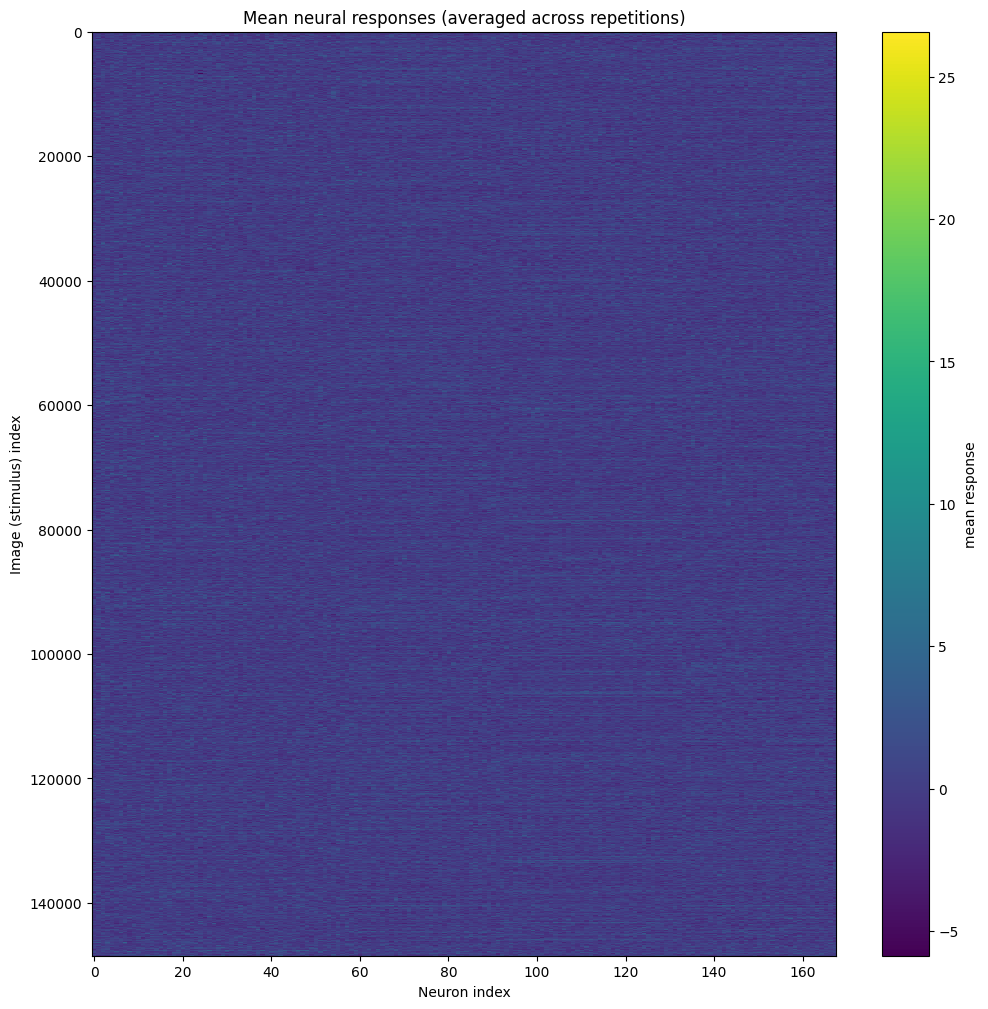

In [48]:
import matplotlib.pyplot as plt

# visualize mean across repetitions -> 2D (image_id, neuroid)
mean_matrix = da.values

plt.figure(figsize=(12, 12))
plt.imshow(mean_matrix, aspect='auto', interpolation='nearest')
plt.colorbar(label='mean response')
plt.xlabel('Neuron index')
plt.ylabel('Image (stimulus) index')
plt.title('Mean neural responses (averaged across repetitions)')
plt.show()

In [11]:
da_u.data.shape


(3200, 168, 51)

In [12]:
n_full = matrix

In [104]:
import numpy as np

def split_half_reliability(X, n_splits=100, eps=1e-8):
    # X: (S, R, N) may contain NaN
    S, R, N = X.shape
    out = np.zeros((n_splits, N))

    for k in range(n_splits):
        idx = np.random.permutation(R)
        h1 = idx[:R//2]
        h2 = idx[R//2:]

        # nan-safe half-averages (S, N)
        m1 = np.nanmean(X[:, h1, :], axis=1)
        m2 = np.nanmean(X[:, h2, :], axis=1)

        # compute correlation per neuron, stimulus-wise ignoring NaNs
        m1c = m1 - np.nanmean(m1, axis=0, keepdims=True)
        m2c = m2 - np.nanmean(m2, axis=0, keepdims=True)

        num = np.nansum(m1c * m2c, axis=0)
        den = np.sqrt(np.nansum(m1c**2, axis=0) *
                      np.nansum(m2c**2, axis=0)) + eps

        r = num / den

        # Spearman–Brown
        out[k] = (2*r) / (1+r+eps)

    return out.mean(axis=0)


split_half_reliability(torch.tensor(matrix)).shape

(168,)

In [120]:
r = split_half_reliability(matrix)
mask = r>=0.7
r = np.where(mask, r, np.nan)
r

array([0.72812219, 0.87375006, 0.89015248, 0.94705966, 0.88011554,
       0.93025741, 0.93877956, 0.92738044, 0.95347369, 0.9614199 ,
       0.96640563,        nan, 0.92466433,        nan, 0.95021068,
       0.81988332, 0.97348116,        nan, 0.96953396, 0.83010291,
       0.96037542, 0.93777042, 0.93371904, 0.94328578,        nan,
       0.89105328, 0.70750686,        nan, 0.79848919, 0.79212627,
              nan,        nan, 0.73111043, 0.7615798 ,        nan,
              nan,        nan, 0.73426166,        nan, 0.87720489,
       0.82937546, 0.75395032, 0.96025315,        nan, 0.96710321,
       0.92260878,        nan,        nan,        nan,        nan,
              nan, 0.93957512,        nan,        nan, 0.72672469,
              nan, 0.90531147,        nan, 0.85041067, 0.88454538,
       0.90257649, 0.83860188, 0.86273376, 0.93466727, 0.84861385,
       0.91332001, 0.85751657, 0.84612514, 0.83184643, 0.90805075,
       0.82598807, 0.72893722, 0.91772826, 0.89105817, 0.80090

In [ ]:
bool_mask = np.isnan(r)
r_mean = r[bool_mask].mean()

array([False, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True, False, False, False,  True,
       False, False, False, False, False, False,  True, False, False,
        True, False, False,  True,  True, False, False,  True,  True,
        True, False,  True, False, False, False, False,  True, False,
       False,  True,  True,  True,  True,  True, False,  True,  True,
       False,  True, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True, False, False, False,  True,
       False,  True, False,  True, False,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True, False,
       False, False,  True,  True,  True, False, False,  True,  True,
        True,  True,

In [ ]:
def split_half_reliability(X, n_splits=100, eps=1e-8):
    # X: (S, R, N) may contain NaN
    S, R, N = X.shape
    out = np.zeros((n_splits, N))

    for k in range(n_splits):
        idx = np.random.permutation(R)
        h1 = idx[:R//2]
        h2 = idx[R//2:]

        # nan-safe half-averages (S, N)
        m1 = np.nanmean(X[:, h1, :], axis=1)
        m2 = np.nanmean(X[:, h2, :], axis=1)

        # compute correlation per neuron, stimulus-wise ignoring NaNs
        m1c = m1 - np.nanmean(m1, axis=0, keepdims=True)
        m2c = m2 - np.nanmean(m2, axis=0, keepdims=True)

        num = np.nansum(m1c * m2c, axis=0)
        den = np.sqrt(np.nansum(m1c**2, axis=0) *
                      np.nansum(m2c**2, axis=0)) + eps

        r = num / den

        # Spearman–Brown
        out[k] = (2*r) / (1+r+eps)

    return out.mean(axis=0)

def filter_reliable(benchmark):
    neural_data = benchmark.transpose('presentation', 'neuroid', 'time_bin')
    benchmark_data_full = neural_data.sel(region='IT')
    da = benchmark_data_full.squeeze('time_bin')
    old_index = da.indexes["presentation"]
    image_ids = old_index.get_level_values("image_id")      # or 'stimulus_id'
    reps      = old_index.get_level_values("repetition")

    new_index = pd.MultiIndex.from_arrays(
        [image_ids, reps],
        names=["image_id", "repetition"],
    )

    da2 = da.copy()
    da2 = da2.assign_coords(presentation=("presentation", new_index))

    da_u = da2.unstack("presentation")

    da_u = da_u.transpose("image_id", "repetition", "neuroid")
    matrix = da_u.values
    r = split_half_reliability(matrix)
    mask = r>=0.7
    r = np.where(mask, r, np.nan)
    bool_mask = np.isnan(r)
    r_mean = r[bool_mask].mean()
    return bool_mask, r_mean

In [19]:
import torch
    # resnet18 = models.resnet18(pretrained=True)
    # cnn = BasicCNN(in_channels=1, out_channels=10)
model = torch.hub.load('facebookresearch/dino:main', 'dino_resnet50')

Using cache found in /mnt/c/Users/samue/.cache/torch/hub/facebookresearch_dino_main
/mnt/c/Users/samue/SynologyDrive/CompNeuro II/Computational_Neuroscience_-25--26/.venv-py311/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/c/Users/samue/SynologyDrive/CompNeuro II/Computational_Neuroscience_-25--26/.venv-py311/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [49]:
# n, m = fetch_activation_matrices(resnet18, dataset, activation_layer="layer4.0.bn1", transforms=three_channel_transform, num_iterations=None)
n, m = fetch_activation_matrices(model, dataset, activation_layer="spatial_pool_stage", transforms=None, num_iterations=None)
m = m.cpu().numpy()
n = n.cpu().numpy()
# bool_mask, r_mean = filter_reliable(benchmark)
# n_r = n[:, bool_mask]
# n_r = (n_r - n_r.mean(axis=0, keepdims=True)) / np.std(n_r, axis=0, keepdims=True)
# n = (n - n.mean(axis=0, keepdims=True)) / np.std(n, axis=0, keepdims=True)
# m = (m - m.mean(axis=0, keepdims=True)) / np.std(m, axis=0, keepdims=True)


using device: cuda


AttributeError: 'ModelCommitment' object has no attribute 'named_modules'

In [33]:
from brainscore_vision import load_model, load_benchmark
import numpy as np

from brainscore_vision.model_interface import BrainModel

benchmark = load_benchmark("MajajHong2015public.IT-pls")
brain_model = load_model("compact_resnet50_robust_IT")

# Brain-Score models expect a StimulusSet, not transformed tensors
stimulus_set = benchmark._assembly.stimulus_set


brain_model.start_recording(recording_target=BrainModel.RecordingTarget.IT, time_bins=[(100, 200)])
# stimuli = load_stimulus_set('FreemanZiemba2013.aperture-public')  # load some images for the model to look at



# Get activations
acts_assembly = brain_model.look_at(stimulus_set)          # xarray DataArray / DataAssembly

print(acts_assembly.dims)
print(acts_assembly.sizes)

# Typically: ('presentation', 'neuroid') – but inspect to be sure
X = acts_assembly.values     # model activations, shape (S, M)

# Neural data from the benchmark assembly
Y_assembly = benchmark._assembly
Y = Y_assembly.values        # neural responses, shape (S, N)

# IMPORTANT: align by presentation/stimulus_id, not by index if you’re unsure:
# example:
# acts_assembly and Y_assembly both have coord 'presentation'
# you can reindex one to the other’s order if needed.


activations:   0%|          | 0/3200 [00:00<?, ?it/s]

layer packaging:   0%|          | 0/1 [00:00<?, ?it/s]

('presentation', 'neuroid')
Frozen({'presentation': 3200, 'neuroid': 168})


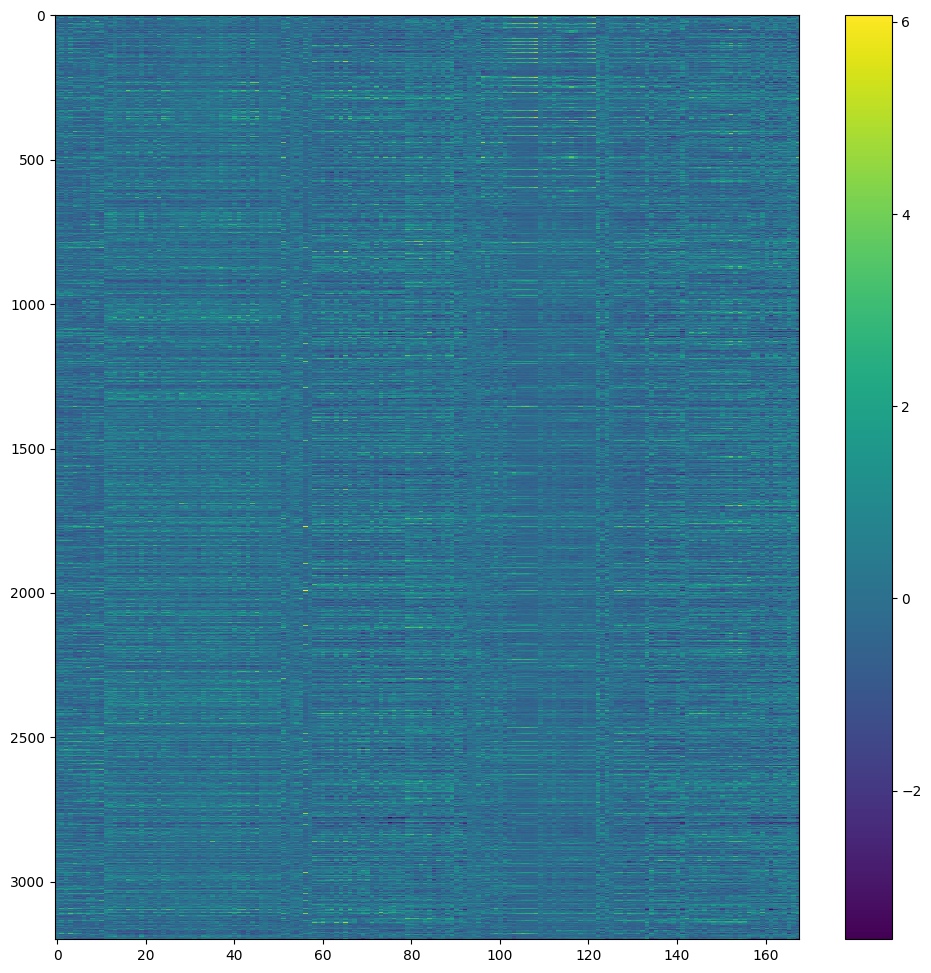

In [51]:
import matplotlib.pyplot as plt

# visualize mean across repetitions -> 2D (image_id, neuroid)
plt.figure(figsize=(12, 12))
plt.imshow(X, aspect='auto', interpolation='nearest')
plt.colorbar()
plt.show()

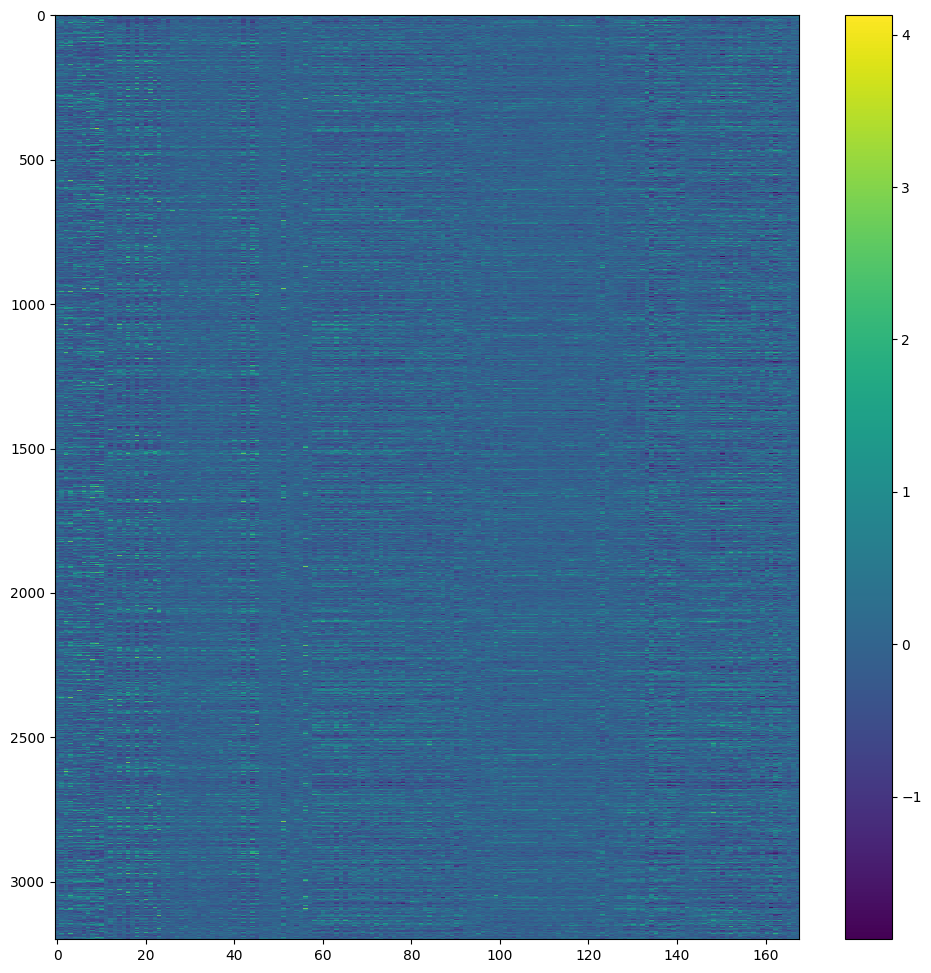

In [52]:
import matplotlib.pyplot as plt

# visualize mean across repetitions -> 2D (image_id, neuroid)
plt.figure(figsize=(12, 12))
plt.imshow(Y, aspect='auto', interpolation='nearest')
plt.colorbar()
plt.show()

In [55]:
from sklearn.metrics import r2_score
f = r2_score(Y, X, multioutput='uniform_average')
f

-5.1313130267315845

In [39]:
X.shape

(3200, 168)

In [40]:
m = X

In [41]:
n_full.shape, m.shape

((3200, 168, 51), (3200, 168))

In [43]:
int(np.isnan(n_full).sum())

0

In [17]:
# replace NaNs with zero in n_full (in-place replacement)
n_full = np.nan_to_num(n_full, nan=0.0)

# quick check
print("NaNs remaining in n_full:", int(np.isnan(n_full).sum()))

NaNs remaining in n_full: 0


In [44]:
# Save arrays to disk (compressed .npz and individual .npy files)
np.savez_compressed("neural_and_model_activations.npz", n_full=n_full, m=m)
np.save("n_full.npy", n_full)
np.save("m.npy", m)
print("Saved: neural_and_model_activations.npz, n_full.npy, m.npy")

Saved: neural_and_model_activations.npz, n_full.npy, m.npy


In [127]:
clf = Ridge(alpha=0)
clf.fit(m, n)
predictions = clf.predict(m)
ev = predictivity(n, predictions, rho_xx=1.0, rho_yy=1.0)
print(ev.mean())

4.243537


In [132]:
clf = Ridge(alpha=1)
clf.fit(m, n_r)
predictions = clf.predict(m)
ev = predictivity(n_r, predictions, rho_xx=r_mean, rho_yy=1.0)
print(ev.mean())

4.9072223


In [39]:
from sklearn.linear_model import Ridge
import numpy as np

# Your model
clf = Ridge(alpha=0)
clf.fit(m, n)
pred = clf.predict(m)
r2_model = clf.score(m, n)

# Baseline: predict mean per neuron
mean_n = np.mean(n, axis=0, keepdims=True)
pred_mean = np.repeat(mean_n, n.shape[0], axis=0)

# R^2 by hand for baseline
ss_res = np.sum((n - pred_mean)**2)
ss_tot = np.sum((n - np.mean(n, axis=0, keepdims=True))**2)
r2_mean = 1 - ss_res / ss_tot

print("R^2 (model):", r2_model)
print("R^2 (mean baseline):", r2_mean)


R^2 (model): 0.042435310781002045
R^2 (mean baseline): 0.0


In [4]:
import matplotlib.pyplot as plt

benchmark_assembly = benchmark._assembly
if hasattr(benchmark_assembly, 'cpu'):
    benchmark_assembly = benchmark_assembly.cpu().numpy()

plt.figure(figsize=(8, 6))
plt.imshow(benchmark_assembly, aspect='auto', interpolation='nearest')
plt.colorbar(label='Firing rate')
plt.xlabel('Neuron index')
plt.ylabel('Stimulus index')
plt.title('Neural response matrix')
plt.show()

NameError: name 'benchmark' is not defined

In [50]:


def F_EV(benchmark, model, activation_layer="fc1", alpha=0.01, transforms=None, num_iterations=None, r2_mode=True, splits=3):
    benchmark_assembly = benchmark._assembly
    dataset = NeuralDataStimuli(benchmark_assembly, trnsfrms=transforms)
    groups = dataset.groups
    skf = StratifiedKFold(n_splits=splits)
    idx = range(len(dataset))

    F_EV_list = []
    n_trains = []
    n_tests = []
    m_trains = []
    m_tests = []
    R_EV_list = []

    all_true = []
    all_pred = []

    for train_index, test_index in skf.split(idx, groups):
        dataset_train = torch.utils.data.Subset(dataset, train_index)
        dataset_test = torch.utils.data.Subset(dataset, test_index)
        clf = Ridge(alpha=alpha)
        n_train, m_train = fetch_activation_matrices(model, dataset_train, activation_layer=activation_layer, transforms=transforms, num_iterations=num_iterations)
        
        print(n_train.shape, m_train.shape)
        if hasattr(n_train, 'cpu'):
            n_train = n_train.cpu().numpy()
        if hasattr(m_train, 'cpu'):
            m_train = m_train.cpu().numpy()
        clf.fit(m_train, n_train)
        n_test, m_test = fetch_activation_matrices(model, dataset_test, activation_layer=activation_layer, transforms=transforms, num_iterations=num_iterations)
        if hasattr(m_test, 'cpu'):
            m_test = m_test.cpu().numpy()
        if hasattr(n_test, 'cpu'):
            n_test = n_test.cpu().numpy()
        train_score = clf.score(m_train, n_train)
        test_score = clf.score(m_test, n_test)
        print(f"Train EV score: {train_score}")
        print(f"Test EV score: {test_score}")
        F_EV_list.append(test_score)
        n_trains.append(n_train)
        n_tests.append(n_test)
        m_trains.append(m_train)
        m_tests.append(m_test)
    return sum(F_EV_list) / len(F_EV_list), n_trains, n_tests, m_trains, m_tests


In [45]:
# from brainscore_vision import load_model
# model = load_model("resnet18_imagenet_full")
# model

In [51]:
# EV_score = F_R_EV(benchmark, cnn, activation_layer="fc1", alpha=0.1, transforms=stimuli_transform)
# print(EV_score)

EV_score_resnet, n_trains_resnet, n_tests_resnet, m_trains_resnet, m_tests_resnet = F_EV(benchmark, resnet18, activation_layer="layer4.0.bn1", alpha=0.001, transforms=three_channel_transform, r2_mode=False)
print(EV_score_resnet)

using device: cuda
torch.Size([2133, 168]) torch.Size([2133, 512])
using device: cuda
Train EV score: 0.24226701259613037
Test EV score: -0.2928617596626282
using device: cuda


KeyboardInterrupt: 

In [48]:
# ...existing code...
def F_EV(benchmark, model, activation_layer="fc1", alpha=None, transforms=None,
         num_iterations=None, r2_mode=True, splits=3, drop_low_variance=True,
         var_threshold=1e-6, do_scaling=True, tune_alphas=None):
    import numpy as np
    from sklearn.linear_model import Ridge, RidgeCV
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import explained_variance_score, r2_score

    benchmark_assembly = benchmark._assembly
    dataset = NeuralDataStimuli(benchmark_assembly, trnsfrms=transforms)
    groups = dataset.groups
    skf = StratifiedKFold(n_splits=splits)
    idx = range(len(dataset))

    F_EV_list = []
    per_fold_info = []

    for fold, (train_index, test_index) in enumerate(skf.split(idx, groups), 1):
        dataset_train = torch.utils.data.Subset(dataset, train_index)
        dataset_test  = torch.utils.data.Subset(dataset, test_index)

        y_train, X_train = fetch_activation_matrices(model, dataset_train,
                                                    activation_layer=activation_layer,
                                                    transforms=transforms,
                                                    num_iterations=num_iterations)
        y_test,  X_test  = fetch_activation_matrices(model, dataset_test,
                                                    activation_layer=activation_layer,
                                                    transforms=transforms,
                                                    num_iterations=num_iterations)

        # to numpy
        if hasattr(X_train, 'cpu'): X_train = X_train.detach().cpu().numpy()
        if hasattr(X_test,  'cpu'): X_test  = X_test.detach().cpu().numpy()
        if hasattr(y_train, 'cpu'): y_train = y_train.detach().cpu().numpy()
        if hasattr(y_test,  'cpu'): y_test  = y_test.detach().cpu().numpy()

        print(f"[fold {fold}] shapes X_train={X_train.shape} y_train={y_train.shape} X_test={X_test.shape} y_test={y_test.shape}")
        print(f"[fold {fold}] NaNs in y_train/y_test: {np.isnan(y_train).any()}/{np.isnan(y_test).any()}")

        var_per_neuron = np.nanvar(y_train, axis=0)
        print(f"[fold {fold}] y_train var min/med/max: {var_per_neuron.min():.3e}/{np.median(var_per_neuron):.3e}/{var_per_neuron.max():.3e}")
        n_low_var = int((var_per_neuron <= var_threshold).sum())
        print(f"[fold {fold}] neurons with var <= {var_threshold}: {n_low_var}/{var_per_neuron.size}")

        # drop low-variance neurons
        if drop_low_variance:
            keep = var_per_neuron > var_threshold
            if keep.sum() == 0:
                raise RuntimeError("All neurons dropped by var_threshold; reduce threshold or set drop_low_variance=False")
            y_train = y_train[:, keep]; y_test = y_test[:, keep]
            print(f"[fold {fold}] kept neurons: {keep.sum()}")

        # scale features
        if do_scaling:
            scaler = StandardScaler(with_mean=True, with_std=True)
            X_train_s = scaler.fit_transform(X_train)
            X_test_s  = scaler.transform(X_test)
        else:
            X_train_s, X_test_s = X_train, X_test

        # choose alpha
        if alpha is None:
            if tune_alphas is None:
                tune_alphas = np.logspace(-6, 2, 9)
            clf_cv = RidgeCV(alphas=tune_alphas, scoring='r2')
            clf_cv.fit(X_train_s, y_train)
            chosen_alpha = float(clf_cv.alpha_)
            print(f"[fold {fold}] RidgeCV chose alpha={chosen_alpha:.3e}")
            clf = Ridge(alpha=chosen_alpha)
        else:
            clf = Ridge(alpha=float(alpha))

        clf.fit(X_train_s, y_train)
        y_pred = clf.predict(X_test_s)

        # baseline mean predictor
        y_mean = np.nanmean(y_train, axis=0)[None, :]
        y_mean_pred = np.repeat(y_mean, y_test.shape[0], axis=0)
        baseline_ev = explained_variance_score(y_test, y_mean_pred, multioutput='variance_weighted')
        model_ev = explained_variance_score(y_test, y_pred, multioutput='variance_weighted')
        baseline_r2 = r2_score(y_test, y_mean_pred, multioutput='variance_weighted')
        model_r2 = r2_score(y_test, y_pred, multioutput='variance_weighted')

        print(f"[fold {fold}] baseline EV={baseline_ev:.4f}, model EV={model_ev:.4f}, baseline R2={baseline_r2:.4f}, model R2={model_r2:.4f}")

        # per-neuron diagnostics (summary)
        try:
            from sklearn.metrics import r2_score as _r2
            per_neuron_r2 = _r2(y_test, y_pred, multioutput='raw_values')
            print(f"[fold {fold}] per-neuron R2 min/med/mean: {np.nanmin(per_neuron_r2):.4f}/{np.nanmedian(per_neuron_r2):.4f}/{np.nanmean(per_neuron_r2):.4f}")
        except Exception:
            per_neuron_r2 = None

        F_EV_list.append(model_ev)
        per_fold_info.append(dict(fold=fold, model_ev=model_ev, model_r2=model_r2, baseline_ev=baseline_ev,
                                  baseline_r2=baseline_r2, chosen_alpha=(getattr(clf, 'alpha', None)),
                                  per_neuron_r2_summary=(None if per_neuron_r2 is None else dict(min=float(np.nanmin(per_neuron_r2)), median=float(np.nanmedian(per_neuron_r2)), mean=float(np.nanmean(per_neuron_r2))))))

    mean_ev = float(np.nanmean(F_EV_list))
    print(f"Mean explained variance across folds: {mean_ev:.4f}")
    return mean_ev, per_fold_info
# ...existing code...

In [1]:
import brainscore_vision
bm = brainscore_vision.load_benchmark('MajajHong2015public.IT-pls')
bm_asm = bm._assembly

ds = brainscore_vision.load_dataset('MajajHong2015.public')   # or whichever dataset key benchmark uses

# quick prints
print("benchmark._assembly dims:", bm_asm.dims)
print("dataset dims:", ds.dims)
print("benchmark coords:", {k: v for k,v in bm_asm.coords.items()})
print("dataset coords:", {k: v for k,v in ds.coords.items()})

# strict equality tests (xarray)
print("identical:", bm_asm.identical(ds))
print("equals:", bm_asm.equals(ds))   # may raise if different types; wrap in try/except if needed

# common differences: try to reproduce bm_asm by selecting region and squeezing time_bin
candidate = ds.sel(region='IT')
if 'time_bin' in candidate.dims and candidate.sizes['time_bin'] == 1:
    candidate = candidate.squeeze('time_bin')
print("candidate.identical:", candidate.identical(bm_asm))

/mnt/c/Users/samue/SynologyDrive/CompNeuro II/Computational_Neuroscience_-25--26/.venv-py311/lib/python3.11/site-packages/brainscore_core/metrics/__init__.py:16: FutureWarning: xarray subclass Score should explicitly define __slots__
  class Score(DataAssembly):


benchmark._assembly dims: ('presentation', 'neuroid')
dataset dims: ('neuroid', 'presentation', 'time_bin')
benchmark coords: {'neuroid': <xarray.NeuronRecordingAssembly 'neuroid' (neuroid: 168)>
array([('Chabo_L_M_5_9', 'M', 9, 'L', 'cIT', 'Chabo', 0.2, 1.8, 5, 'IT'),
       ('Chabo_L_M_6_9', 'M', 9, 'L', 'cIT', 'Chabo', 0.6000000000000001, 1.8, 6, 'IT'),
       ('Chabo_L_M_5_8', 'M', 8, 'L', 'cIT', 'Chabo', 0.2, 1.4000000000000001, 5, 'IT'),
       ('Chabo_L_M_7_9', 'M', 9, 'L', 'cIT', 'Chabo', 1.0, 1.8, 7, 'IT'),
       ('Chabo_L_M_6_8', 'M', 8, 'L', 'cIT', 'Chabo', 0.6000000000000001, 1.4000000000000001, 6, 'IT'),
       ('Chabo_L_M_7_8', 'M', 8, 'L', 'cIT', 'Chabo', 1.0, 1.4000000000000001, 7, 'IT'),
       ('Chabo_L_M_9_7', 'M', 7, 'L', 'cIT', 'Chabo', 1.8, 1.0, 9, 'IT'),
       ('Chabo_L_M_7_7', 'M', 7, 'L', 'cIT', 'Chabo', 1.0, 1.0, 7, 'IT'),
       ('Chabo_L_M_9_5', 'M', 5, 'L', 'cIT', 'Chabo', 1.8, 0.2, 9, 'IT'),
       ('Chabo_L_M_8_6', 'M', 6, 'L', 'cIT', 'Chabo', 1.4000000

In [2]:
bm_asm

<xarray.NeuronRecordingAssembly 'dicarlo.MajajHong2015.public' (
                                                                presentation: 3200,
                                                                neuroid: 168)>
array([[ 0.08579675, -0.40017223, -0.48299602, ...,  0.44299307,
         0.23595507,  0.00478193],
       [ 0.1961998 ,  0.10559011,  0.4308994 , ...,  0.25456306,
        -0.10369828,  0.40033734],
       [ 0.01543091, -0.5408685 , -0.32352096, ...,  0.27328926,
         0.24315262, -0.05489631],
       ...,
       [ 0.3541822 ,  0.29962146,  0.6635341 , ...,  0.3615814 ,
         0.31918818,  0.27234784],
       [ 0.11517322, -0.01251979, -0.55534226, ...,  0.2850026 ,
         0.34246004,  0.15940946],
       [-0.25128886, -0.22716913, -0.40659687, ..., -0.01127249,
        -0.24650788, -0.16409135]], dtype=float32)
Coordinates:
  * neuroid          (neuroid) MultiIndex
  - neuroid_id       (neuroid) object 'Chabo_L_M_5_9' ... 'Tito_L_M_8_0'
  - arr              (neuroid) object 'M' 'M' 'M' 'M' 'M' ... 'M' 'M' 'M' 'M'
  - col              (neuroid) int64 9 9 8 9 8 8 7 7 5 6 ... 1 0 1 0 1 0 0 1 1 0
  - hemisphere       (neuroid) object 'L' 'L' 'L' 'L' 'L' ... 'L' 'L' 'L' 'L'
  - subregion        (neuroid) object 'cIT' 'cIT' 'cIT' ... 'pIT' 'pIT' 'pIT'
  - animal           (neuroid) object 'Chabo' 'Chabo' 'Chabo' ... 'Tito' 'Tito'
  - y                (neuroid) float64 0.2 0.6 0.2 1.0 0.6 ... 1.0 1.0 1.8 1.4
  - x                (neuroid) float64 1.8 1.8 1.4 1.8 ... -1.8 -1.4 -1.4 -1.8
  - row              (neuroid) int64 5 6 5 7 6 7 9 7 9 8 ... 4 4 5 5 6 6 7 7 9 8
  - region           (neuroid) object 'IT' 'IT' 'IT' 'IT' ... 'IT' 'IT' 'IT'
    time_bin         object (70, 170)
  * presentation     (presentation) MultiIndex
  - image_id         (presentation) object '0015b49a190e9bce70b108b28dc1a0674...
  - stimulus         (presentation) int64 212 161 1734 1634 ... 990 253 1818 323
  - stimulus_id      (presentation) object '0015b49a190e9bce70b108b28dc1a0674...
  - id               (presentation) int64 210 802 2367 2268 ... 894 2451 964
  - background_id    (presentation) object '561c84a23fcc11df50a1c441a23d19cb4...
  - s                (presentation) float64 1.0 1.133 0.9617 ... 0.916 0.7786
  - image_file_name  (presentation) object 'DTUG_L_rx+00.000_ry+00.000_rz+00....
  - filename         (presentation) object 'DTUG_L_rx+00.000_ry+00.000_rz+00....
  - rxy              (presentation) float64 -0.0 19.93 -41.9 ... 35.54 -34.78
  - tz               (presentation) float64 0.0 0.009 0.549 ... 0.297 0.485
  - category_name    (presentation) object 'Boats' 'Animals' ... 'Cars' 'Tables'
  - rxz_semantic     (presentation) float64 0.0 43.35 13.67 ... 36.42 -8.024
  - ty               (presentation) float64 0.0 0.068 -0.263 ... -0.12 0.173
  - ryz              (presentation) float64 -0.0 38.46 23.85 ... 6.701 -25.66
  - object_name      (presentation) object 'ship2' 'bear' ... 'table0'
  - variation        (presentation) int64 0 3 3 3 3 3 3 3 3 ... 3 3 3 3 3 3 3 3
  - size             (presentation) float64 256.0 256.0 256.0 ... 256.0 256.0
  - rxy_semantic     (presentation) float64 90.0 109.9 -131.9 ... 125.5 -34.78
  - ryz_semantic     (presentation) float64 -0.0 38.46 23.85 ... 6.701 -25.66
  - rxz              (presentation) float64 0.0 43.35 13.67 ... 36.42 -8.024
Attributes:
    stimulus_set_identifier:  hvm-public
    stimulus_set:                     id                             backgrou...
    identifier:               dicarlo.MajajHong2015.public

In [3]:
ds

<xarray.NeuronRecordingAssembly 'dicarlo.MajajHong2015.public' (neuroid: 256,
                                                                presentation: 148480,
                                                                time_bin: 1)>
dask.array<open_dataset-30d7fd568d61a4a5770f4cf1b2f7778fdicarlo.MajajHong2015.public, shape=(256, 148480, 1), dtype=float32, chunksize=(256, 148480, 1), chunktype=numpy.ndarray>
Coordinates:
  * neuroid          (neuroid) MultiIndex
  - neuroid_id       (neuroid) object 'Chabo_L_M_5_9' ... 'Tito_L_M_8_0'
  - arr              (neuroid) object 'M' 'M' 'M' 'M' 'M' ... 'M' 'M' 'M' 'M'
  - col              (neuroid) int64 9 9 8 9 8 8 7 7 5 6 ... 1 0 1 0 1 0 0 1 1 0
  - hemisphere       (neuroid) object 'L' 'L' 'L' 'L' 'L' ... 'L' 'L' 'L' 'L'
  - subregion        (neuroid) object 'cIT' 'cIT' 'cIT' ... 'pIT' 'pIT' 'pIT'
  - animal           (neuroid) object 'Chabo' 'Chabo' 'Chabo' ... 'Tito' 'Tito'
  - y                (neuroid) float64 0.2 0.6 0.2 1.0 0.6 ... 1.0 1.0 1.8 1.4
  - x                (neuroid) float64 1.8 1.8 1.4 1.8 ... -1.8 -1.4 -1.4 -1.8
  - region           (neuroid) object 'IT' 'IT' 'IT' 'IT' ... 'IT' 'IT' 'IT'
  - row              (neuroid) int64 5 6 5 7 6 7 9 7 9 8 ... 4 4 5 5 6 6 7 7 9 8
  * presentation     (presentation) MultiIndex
  - image_id         (presentation) object '8a72e2bfdb8c267b57232bf96f069374d...
  - repetition       (presentation) int64 0 18 18 18 18 18 ... 16 16 16 17 17 17
  - stimulus         (presentation) int64 0 426 427 428 429 ... 2569 2566 0 1 2
  - stimulus_id      (presentation) object '8a72e2bfdb8c267b57232bf96f069374d...
  - id               (presentation) int64 1 418 419 420 421 ... 3197 641 642 643
  - background_id    (presentation) object 'ecd40f3f6d7a4d6d88134d648884e0b9b...
  - s                (presentation) float64 1.0 1.0 1.0 ... 1.246 1.296 0.9114
  - image_file_name  (presentation) object 'astra_rx+00.000_ry+00.000_rz+00.0...
  - filename         (presentation) object 'astra_rx+00.000_ry+00.000_rz+00.0...
  - rxy              (presentation) float64 -0.0 -0.0 -0.0 ... 0.02724 -10.4
  - tz               (presentation) float64 0.0 0.0 0.0 ... -0.269 -0.599 0.211
  - category_name    (presentation) object 'Cars' 'Faces' ... 'Fruits' 'Fruits'
  - rxz_semantic     (presentation) float64 0.0 0.0 0.0 ... 13.22 -2.621 -14.72
  - ty               (presentation) float64 0.0 0.0 0.0 ... -0.191 -0.213 0.277
  - ryz              (presentation) float64 -0.0 -0.0 -0.0 ... -16.89 -0.2055
  - object_name      (presentation) object 'car_astra' 'face0' ... 'apple'
  - variation        (presentation) int64 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  - size             (presentation) float64 256.0 256.0 256.0 ... 256.0 256.0
  - rxy_semantic     (presentation) float64 90.0 -0.0 -0.0 ... 0.02724 -10.4
  - ryz_semantic     (presentation) float64 -0.0 -0.0 -0.0 ... -16.89 -0.2055
  - rxz              (presentation) float64 0.0 0.0 0.0 ... 13.22 -2.621 -14.72
  * time_bin         (time_bin) MultiIndex
  - time_bin_start   (time_bin) int64 70
  - time_bin_end     (time_bin) int64 170
Attributes:
    stimulus_set_identifier:  hvm-public
    stimulus_set:                     id                             backgrou...
    identifier:               dicarlo.MajajHong2015.public

In [23]:
import pandas as pd
neural_data = brainscore_vision.load_dataset("MajajHong2015.public")
neural_data = neural_data.transpose('presentation', 'neuroid', 'time_bin')
benchmark_data_full = neural_data.sel(region='IT')
da = benchmark_data_full.squeeze('time_bin')
old_index = da.indexes["presentation"]
image_ids = old_index.get_level_values("image_id")
reps      = old_index.get_level_values("repetition")
new_index = pd.MultiIndex.from_arrays(
        [image_ids, reps],
        names=["image_id", "repetition"],
    )
da2 = da.copy()
da2 = da2.assign_coords(presentation=("presentation", new_index))
da_u = da2.unstack("presentation")

da_u = da_u.transpose("image_id", "repetition", "neuroid")
matrix = da_u.values

In [24]:
import numpy as np
collapsed_matrix = np.nanmean(matrix, axis=1)  # average across repetitions

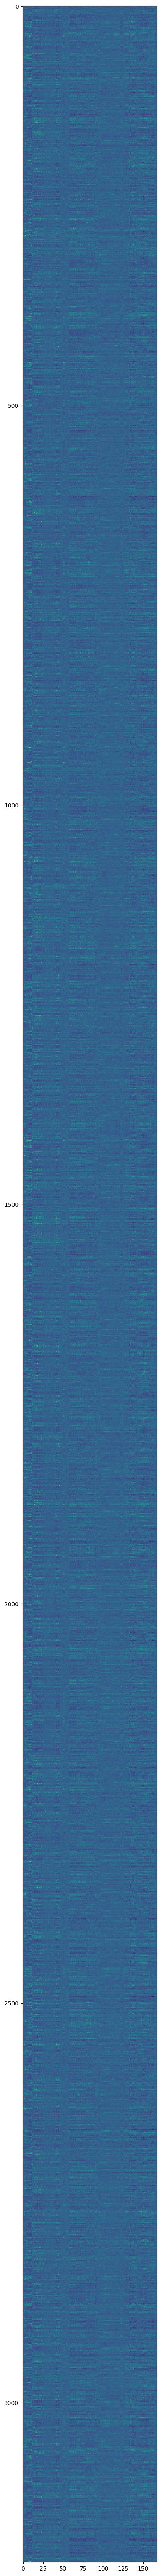

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 80))
plt.imshow(collapsed_matrix)

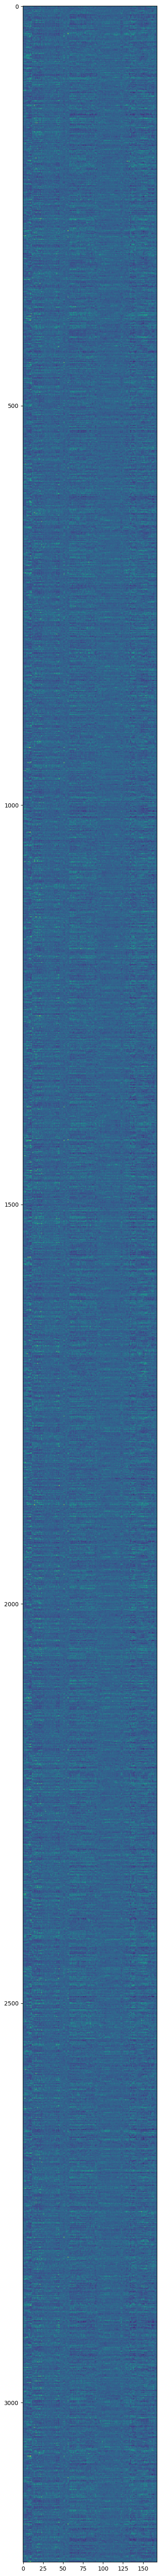

In [32]:
benchmark = brainscore_vision.load_benchmark('MajajHong2015public.IT-pls')
benchmark_assembly = benchmark._assembly
matrix_2 = benchmark_assembly.data

matrix_2.shape

plt.figure(figsize=(10, 80))
plt.imshow(matrix_2)

In [31]:
np.array_equal(collapsed_matrix, matrix_2)

False